In [20]:
import torch
import torch.nn.functional as F
import numpy as np
import math
from typing import List, Tuple, Dict


# Define the Laplacian kernel at the module level for efficiency.
# It's a 5-point stencil for a 2D grid.
_LAPLACIAN_KERNEL = torch.tensor([[0., 1., 0.], [1., -4., 1.], [0., 1., 0.]]).view(1, 1, 3, 3)

def _compute_laplacian_2d(grid: torch.Tensor, dx: float) -> torch.Tensor:
    """
    Computes the 2D Laplacian of a grid using a 5-point stencil convolution.
    Handles No-Flux (Neumann) boundary conditions via 'replicate' padding.

    Args:
        grid (torch.Tensor): The input grid of shape [batch_size, N, N].
        dx (float): The spatial step size.

    Returns:
        torch.Tensor: The computed Laplacian of the grid.
    """
    # The kernel must be on the same device as the input grid.
    kernel = _LAPLACIAN_KERNEL.to(grid.device)
    
    # Add a channel dimension for conv2d compatibility: [B, N, N] -> [B, 1, N, N].
    grid_ch = grid.unsqueeze(1)
    
    # Pad the grid by one layer on all sides. 'replicate' mode copies the edge
    # values, which is a standard way to implement Neumann boundary conditions
    # for a finite difference scheme.
    padded_grid = F.pad(grid_ch, (1, 1, 1, 1), mode='replicate')
    
    # Apply the convolution. 'valid' padding means no extra padding is added by the conv layer itself.
    laplacian = F.conv2d(padded_grid, kernel, padding='valid')
    
    # Scale the result by 1/dx^2 and remove the channel dimension to get the final result.
    return laplacian.squeeze(1) / (dx**2)

def _compute_reactions(u: torch.Tensor, v: torch.Tensor, w: torch.Tensor, params: Dict) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Computes the reaction terms (RHS of the ODEs) for the PDE system.
    This function is fully vectorized using PyTorch operations.

    Args:
        u, v, w (torch.Tensor): Current state variables.
        params (Dict): Dictionary of model parameters.

    Returns:
        Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: The reaction terms for u, v, and w.
    """
    # Heaviside step functions are implemented as boolean masks converted to float (0.0 or 1.0).
    H_uc = (u >= params['V_c']).float()
    H_uv = (u >= params['V_v']).float()

    # Calculate ionic currents as per the model equations.
    I_fi = -v * H_uc * (u - params['V_c']) * (1 - u) / params['tau_d']
    I_so = u * (1 - H_uc) / params['tau_0'] + H_uc / params['tau_r']
    I_si = -w * (1 + torch.tanh(params['k'] * (u - params['V_csi']))) / (2 * params['tau_si'])

    # Total reaction term for u (dudt_reaction). Note: the PDE has a minus sign before this term.
    dudt_reaction = (I_fi + I_so + I_si) / params['C_m']

    # Gating variable v's time constant (tau_mv) is dependent on u.
    tau_mv = (1.0 - H_uv) * params['tau_v1'] + H_uv * params['tau_v2']

    # dv/dt is computed using torch.where for conditional logic based on u.
    dvdt = torch.where(
        u < params['V_c'],
        (1.0 - v) / tau_mv,
        -v / params['tau_pv']
    )

    # dw/dt is also computed using torch.where for its conditional logic.
    dwdt = torch.where(
        u < params['V_c'],
        (1.0 - w) / params['tau_mw'],
        -w / params['tau_pw']
    )

    return dudt_reaction, dvdt, dwdt

def solver(u_init: np.ndarray, 
           v_init: np.ndarray, 
           w_init: np.ndarray, 
           fk_taud: float, 
           t_eval: List[float]) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Solves the 2D reaction-diffusion system for a batch of initial conditions
    using the Forward Euler method on a GPU-accelerated backend.

    Args:
        u_init (np.ndarray): Initial conditions for u, shape [batch_size, N, N].
        v_init (np.ndarray): Initial conditions for v, shape [batch_size, N, N].
        w_init (np.ndarray): Initial conditions for w, shape [batch_size, N, N].
        fk_taud (float): Model parameter tau_d.
        t_eval (List[float]): A list of time points at which to evaluate and return the solution.

    Returns:
        Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: A tuple containing the solutions
        for u, v, and w at the specified time points (including t=0). Each tensor has a
        shape of [batch_size, len(t_eval) + 1, N, N].
    """
    # 1. Setup device and parameters
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    params = {
        'diffCoef': 0.001, 'C_m': 1.0, 'tau_pv': 7.99, 'tau_v1': 9.8,
        'tau_v2': 312.5, 'tau_pw': 870.0, 'tau_mw': 41.0, 'tau_d': fk_taud,
        'tau_0': 12.5, 'tau_r': 33.83, 'tau_si': 29.0, 'k': 10.0,
        'V_csi': 0.861, 'V_c': 0.13, 'V_v': 0.04
    }

    # 2. Discretization setup
    if u_init.shape[1] != u_init.shape[2]:
        raise ValueError("Spatial domain must be square (N x N).")
    N = u_init.shape[1]
    domain_size = 10.0 
    dx = domain_size / (N)

    # Choose a small, fixed time step `dt` for the Forward Euler method.
    # A conservative value is chosen to maintain stability, which is often
    # dictated by the fastest reaction dynamics in such systems.
    dt = 0.025
    print(f"Spatial step dx = {dx:.4f}, Time step dt = {dt:.4f}")

    # 3. Initialization
    # Convert numpy inputs to torch tensors, set data type, and move to the selected device.
    u = torch.from_numpy(u_init).float().to(device)
    v = torch.from_numpy(v_init).float().to(device)
    w = torch.from_numpy(w_init).float().to(device)

    # Ensure t_eval is sorted to process time points chronologically.
    t_eval_sorted = sorted(t_eval)
    
    # Store results in lists. Start with the initial state (t=0).
    # We clone and move to CPU to prevent GPU memory accumulation and modification of stored states.
    u_all = [u.cpu().clone()]
    v_all = [v.cpu().clone()]
    w_all = [w.cpu().clone()]

    # 4. Main time-stepping loop
    current_t = 0.0
    
    for i, target_t in enumerate(t_eval_sorted):
        # Ensure we don't simulate backwards if target_t is less than current_t
        if target_t > current_t:
            # Calculate the number of steps required to reach the next evaluation time.
            num_steps = math.ceil((target_t - current_t) / dt)
            
            for _ in range(num_steps):
                # Calculate the diffusion term (Laplacian) for u.
                lap_u = _compute_laplacian_2d(u, dx)
                dudt_diffusion = params['diffCoef'] * lap_u
                
                # Calculate the reaction terms for all three variables.
                dudt_reaction, dvdt, dwdt = _compute_reactions(u, v, w, params)
                
                # Perform the Forward Euler update step for each variable.
                # Note the minus sign for dudt_reaction, as specified in the PDE.
                u = u + dt * dudt_diffusion - dt * dudt_reaction
                v = v + dt * dvdt
                w = w + dt * dwdt
            
            # Update the simulation time to reflect the steps taken.
            current_t += num_steps * dt
        
        print(f"Reached evaluation time point {target_t} at simulation time {current_t:.2f} (step {i+1}/{len(t_eval_sorted)})")

        # Store the computed state at the current time point.
        u_all.append(u.cpu().clone())
        v_all.append(v.cpu().clone())
        w_all.append(w.cpu().clone())

    # 5. Output formatting
    # Stack the list of tensors along a new time dimension (dim=1).
    # The output shape will be [batch_size, len(t_eval) + 1, N, N].
    # Note: The requested output shape [..., N] in the prompt is assumed to be a typo
    # for a 2D problem, so [..., N, N] is produced.
    u_out = torch.stack(u_all, dim=1)
    v_out = torch.stack(v_all, dim=1)
    w_out = torch.stack(w_all, dim=1)
    
    print("Solver finished.")

    return u_out, v_out, w_out

In [16]:
import torch

# Define model parameters
D = 0.001
C_m = 1.0
tau_pv = 7.99
tau_v1 = 9.8
tau_v2 = 312.5
tau_pw = 870.0
tau_mw = 41.0
tau_0 = 12.5
tau_r = 33.83
tau_si = 29.0
k = 10.0
V_csi = 0.861
V_c = 0.13
V_v = 0.04
tau_d = 0.5714

# Spatial and temporal parameters
N = 512
dx = 0.00390625
T = 100.0
dt = 0.025

def heaviside(x):
    # Heaviside step function
    return (x >= 0).float()

def fi_current(u, v):
    # I_fi current term
    return (-v * heaviside(u - V_c) * (u - V_c) * (1 - u) / tau_d)

def so_current(u):
    # I_so current term
    return (u * (1 - heaviside(u - V_c)) / tau_0 + heaviside(u - V_c) / tau_r)

def si_current(u, w):
    # I_si current term
    return (-w * (1 + torch.tanh(k * (u - V_csi))) / (2 * tau_si))

def update_u( u, v, w):
    # Update u based on the PDE equation
    du_dt = D * ((torch.roll(u, 1, 2) - 2 * u + torch.roll(u, -1, 2)) +
                  (torch.roll(u, 1, 1) - 2 * u + torch.roll(u, -1, 1)))
    du_dt -= (fi_current(u, v) + so_current(u) + si_current(u, w)) / C_m
    return u + dt * du_dt

def update_v( u, v):
    # Update v based on the PDE equation
    if torch.any(u < V_c):
        dv_dt = (1 - v) / tau_pv
    else:
        dv_dt = -v / tau_pw
    return v + dt * dv_dt

def update_w( u, w):
    # Update w based on the PDE equation
    if torch.any(u < V_c):
        dw_dt = (1 - w) / tau_mw
    else:
        dw_dt = -w / tau_pw
    return w + dt * dw_dt

def solver( u0, v0, w0, T=T, dt=dt):
    """
    Solve the PDE system using a forward Euler method.

    :param  Number of data points in the batch.
    :param u0: Initial transmembrane potential values [ N, N].
    :param v0: Initial gating variable v values [ N, N].
    :param w0: Initial gating variable w values [ N, N].
    :param T: Total simulation time.
    :param dt: Time step for forward Euler method.
    :return: Predicted u, v, w after T seconds.
    """
    # Initialize variables
    u = u0
    v = v0
    w = w0

    # Simulate the PDE over the specified time horizon
    t = 0.0
    while t < T:
        print(f"Time: {t:.2f}")
        
        # Update u, v, w using the PDE equations
        u = update_u( u, v, w)
        v = update_v( u, v)
        w = update_w( u, w)
        
        t += dt

    return u, v, w


[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]


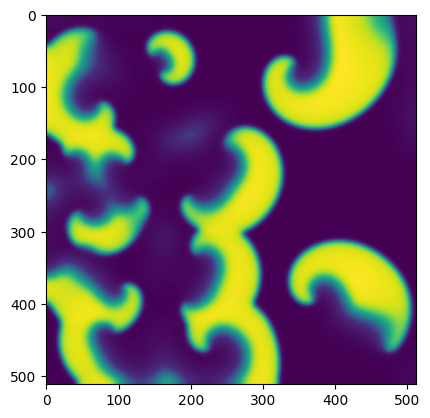

In [5]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt

fk_taud = 0.5714
t_eval = []
folder_path = f'../fk_data/tau_d_{fk_taud}/'
data_path = os.path.join(folder_path, 'UVW_array_data.npz')
data = np.load(data_path)

# Access the arrays
U_init = data['U'][0:1]
V_init = data['V'][0:1]
W_init = data['W'][0:1]

all_files = os.listdir(folder_path)
time = []
for f in all_files:
    if f.startswith('sim_data_') and f.endswith('.csv'):
        match = re.findall(r"[-+]?\d*\.\d+|\d+", f)
        if match:
            time.append(float(match[0]))
time.sort()

time = [t - min(time) for t in time] 

print(time)
# plot U
plt.imshow(U_init[0])

In [17]:
u_out, v_out, w_out = solver(torch.from_numpy(U_init), torch.from_numpy(V_init), torch.from_numpy(W_init))

Time: 0.00
Time: 0.03
Time: 0.05
Time: 0.08
Time: 0.10
Time: 0.12
Time: 0.15
Time: 0.17
Time: 0.20
Time: 0.22
Time: 0.25
Time: 0.27
Time: 0.30
Time: 0.33
Time: 0.35
Time: 0.38
Time: 0.40
Time: 0.43
Time: 0.45
Time: 0.48
Time: 0.50
Time: 0.53
Time: 0.55
Time: 0.58
Time: 0.60
Time: 0.63
Time: 0.65
Time: 0.68
Time: 0.70
Time: 0.73
Time: 0.75
Time: 0.78
Time: 0.80
Time: 0.83
Time: 0.85
Time: 0.88
Time: 0.90
Time: 0.93
Time: 0.95
Time: 0.98
Time: 1.00
Time: 1.03
Time: 1.05
Time: 1.08
Time: 1.10
Time: 1.12
Time: 1.15
Time: 1.17
Time: 1.20
Time: 1.22
Time: 1.25
Time: 1.27
Time: 1.30
Time: 1.32
Time: 1.35
Time: 1.37
Time: 1.40
Time: 1.42
Time: 1.45
Time: 1.47
Time: 1.50
Time: 1.52
Time: 1.55
Time: 1.57
Time: 1.60
Time: 1.62
Time: 1.65
Time: 1.67
Time: 1.70
Time: 1.72
Time: 1.75
Time: 1.77
Time: 1.80
Time: 1.82
Time: 1.85
Time: 1.87
Time: 1.90
Time: 1.92
Time: 1.95
Time: 1.97
Time: 2.00
Time: 2.02
Time: 2.05
Time: 2.07
Time: 2.10
Time: 2.12
Time: 2.15
Time: 2.17
Time: 2.20
Time: 2.22
Time: 2.25

tensor(0.7008, dtype=torch.float64)


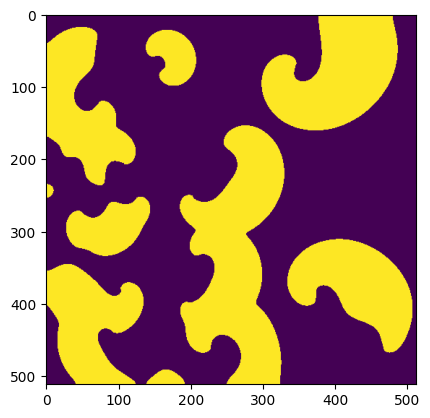

In [29]:
plt.imshow(u_out[0])
rmse = torch.sqrt(torch.mean((u_out[0] - torch.from_numpy(data['U'][-1]))**2)) 
print(rmse)

In [22]:
u_out, v_out, w_out = solver(U_init, V_init, W_init, fk_taud, t_eval=time)

Using device: cuda
Spatial step dx = 0.0195, Time step dt = 0.0250
Reached evaluation time point 0.0 at simulation time 0.00 (step 1/11)
Reached evaluation time point 10.0 at simulation time 10.00 (step 2/11)
Reached evaluation time point 20.0 at simulation time 20.00 (step 3/11)
Reached evaluation time point 30.0 at simulation time 30.00 (step 4/11)
Reached evaluation time point 40.0 at simulation time 40.00 (step 5/11)
Reached evaluation time point 50.0 at simulation time 50.00 (step 6/11)
Reached evaluation time point 60.0 at simulation time 60.00 (step 7/11)
Reached evaluation time point 70.0 at simulation time 70.00 (step 8/11)
Reached evaluation time point 80.0 at simulation time 80.00 (step 9/11)
Reached evaluation time point 90.0 at simulation time 90.00 (step 10/11)
Reached evaluation time point 100.0 at simulation time 100.00 (step 11/11)
Solver finished.


TypeError: Invalid shape (512,) for image data

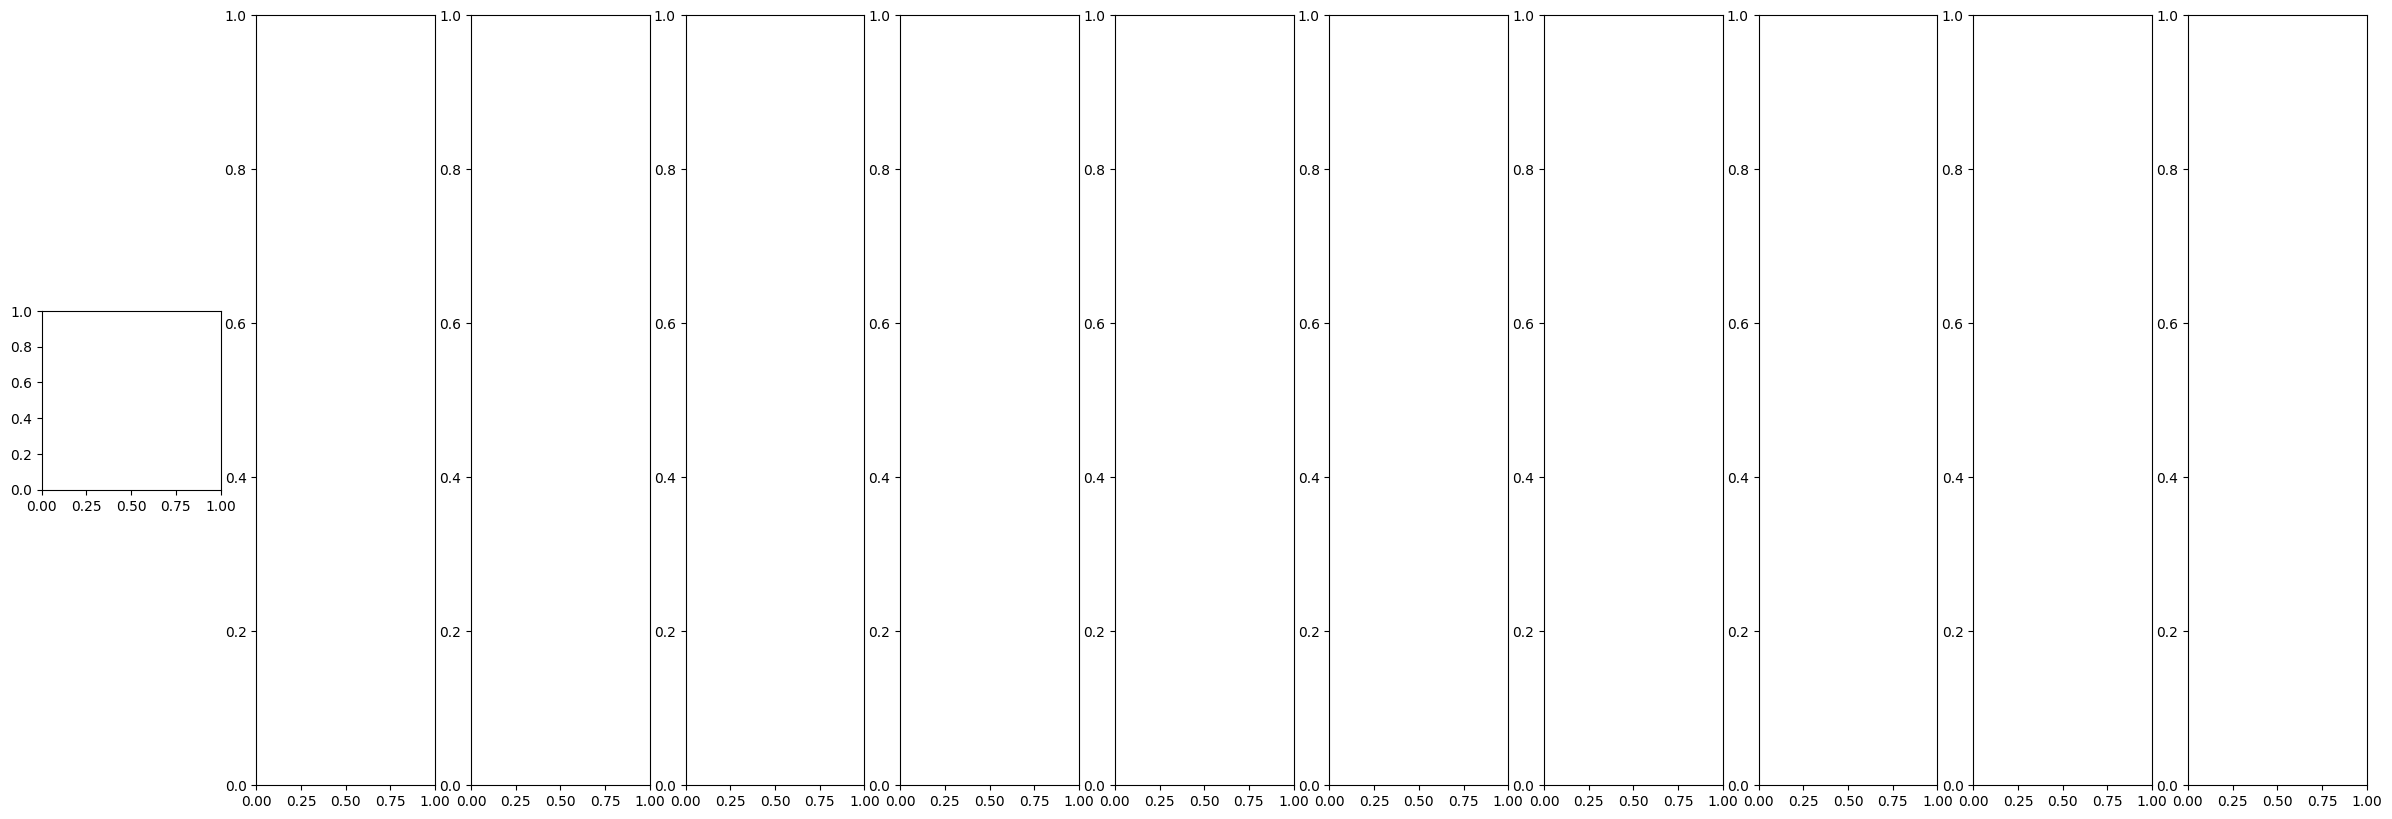

In [18]:
fig, axes = plt.subplots(1, len(time), figsize=(30, 10))
# show all time figure, retain prev time figure
for t in range(len(time)):
    axes[t].imshow(u_out[0, t])
    axes[t].axis('off')

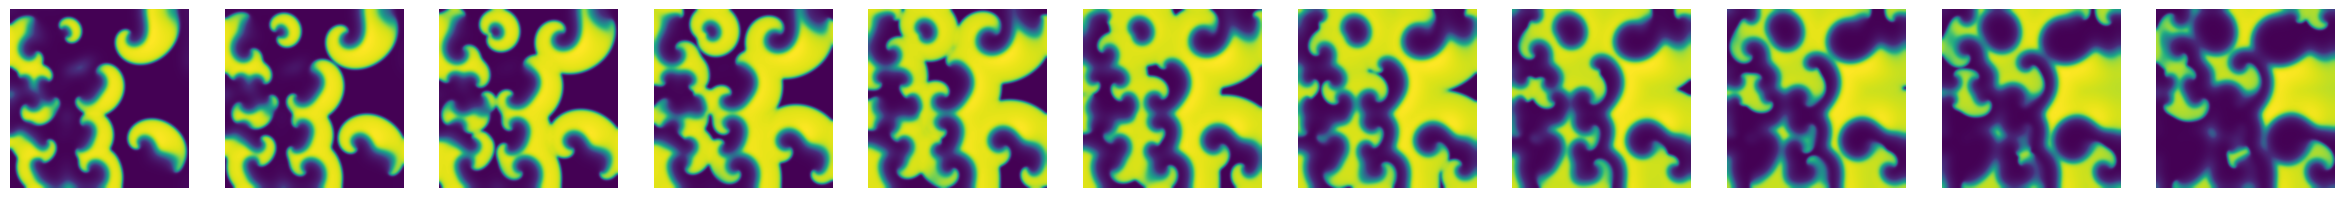

In [24]:
fig, axes = plt.subplots(1, len(time), figsize=(30, 10))
# show all time figure, retain prev time figure
for t in range(len(time)):
    axes[t].imshow(data['U'][t])
    axes[t].axis('off')

Final RMSE at t=100.0: 0.000037


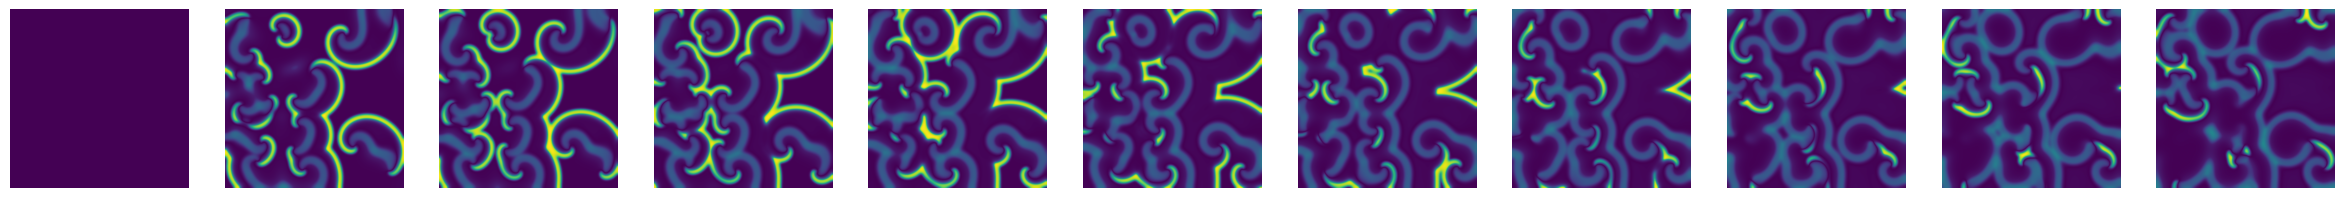

: 

In [ ]:
# plot difference 
fig, axes = plt.subplots(1, len(time), figsize=(30, 10))
# show all time figure, retain prev time figure
for t in range(len(time)):
    diff = torch.abs(u_out[0, t] - torch.from_numpy(data['U'][t]))
    axes[t].imshow(diff)
    axes[t].axis('off')
# print final RMSE
rmse = torch.sqrt(torch.mean((u_out[0, -1] - torch.from_numpy(data['U'][-1]))**2)) 
print(f"Final RMSE at t={time[-1]}: {rmse.item():.6f}")